# CW01

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider
import scipy

# 1. Free Space Wave Propagation

Try to simulate the following scenario:
A plane wave is illuminating a diffraction grating with 10µm spacing. The grating itself has a size of 100µm in both dimensions. The wavelength is 633nm. Use 1024 data points for each dimension. The overall array size is 1mm.


Include the following keywords for ChatGPT to generate the code:
- Optical Wave Propagation function based on the Angular Spectrum
- Python numpy
- the given function signature for the angular spectrum

## 1.1 
Propagate 1mm in propagation distance. Plot both the intensity of the initial field and also the intensity for the 1mm propagated field.
Change the grating spacing, what happens?

## 1.2
Answer for which z distance the different diffraction components separate (orders of the grating). Give geometrical reasoning for this value.
*Think about which spatialy frequency of the grating results in which angle of propagation*.

You can use the interactive sliders to play around.


## 1.3
Can you adapt the code (use ChatGPT) to propagate for many different z values.
Plot the cross section of x-z.

## 1.4
What happens for very long propagation distances such as 50mm, 100mm? Is the result physical correct? Why do you think so?


In [5]:

def angular_spectrum_propagation(U0, wvl, d, dx):
    """
    Propagates an optical field using the Angular Spectrum Method.

    Parameters:
        U0  : 2D numpy array (input wavefield)
        wvl : float (wavelength of light in meters)
        d   : float (propagation distance in meters)
        dx  : float (sampling interval in meters)

    Returns:
        U   : 2D numpy array (propagated wavefield)
    """

    # Get array size
    ny, nx = U0.shape
    k = 2 * np.pi / wvl  # Wave number

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)

    # Compute transfer function
    H = np.exp(1j * k * d * np.sqrt(1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))
    H[np.isnan(H)] = 0  # Remove undefined values

    # Compute angular spectrum
    U0_spectrum = np.fft.fft2(U0)
    U_spectrum = U0_spectrum * H

    # Inverse FFT to obtain propagated field
    U = np.fft.ifft2(U_spectrum)

    return U

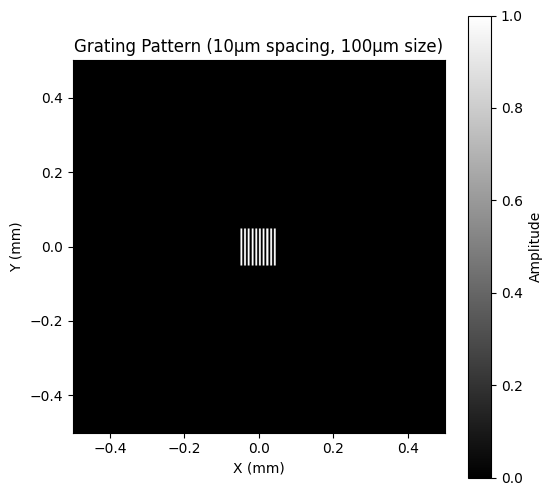

In [6]:
# Define parameters
array_size = 1e-3  # 1mm total size
num_pixels = 1024  # Resolution
grating_period = 10e-6  # 10µm period
grating_size = 100e-6  # 100µm grating width
dx = array_size / num_pixels  # Pixel size

wvl = 633e-9


# Create spatial coordinate grid
x = np.linspace(-array_size / 2, array_size / 2, num_pixels)
y = np.linspace(-array_size / 2, array_size / 2, num_pixels)
X, Y = np.meshgrid(x, y)

# Generate grating within the specified region
grating = (np.mod(X, grating_period) < grating_period / 2).astype(float)

# Apply aperture to keep only a central grating region
aperture = (np.abs(X) < (grating_size / 2)) * (np.abs(Y) < (grating_size / 2))
grating *= aperture  # Apply aperture mask

# Display the grating
plt.figure(figsize=(6, 6))
plt.imshow(grating, cmap="gray", extent=[-0.5, 0.5, -0.5, 0.5])
plt.colorbar(label="Amplitude")
plt.title("Grating Pattern (10µm spacing, 100µm size)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.show()


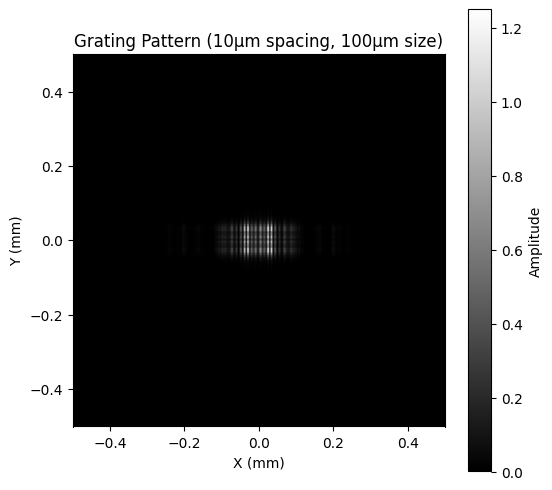

In [7]:
# Display the grating
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(angular_spectrum_propagation(grating, wvl, 1e-3, dx))**2, cmap="gray", extent=[-0.5, 0.5, -0.5, 0.5])
plt.colorbar(label="Amplitude")
plt.title("Grating Pattern (10µm spacing, 100µm size)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.show()

# 1.2

The grating spacing $d$ corresponds to a k vector of  $k_g\frac{2\pi}{d}$. A k-vector corresponds to a certain angle propagating.
The angle can be calculated with $\sin(\alpha) = \frac{k_g}{k}$ where $k=\frac{2\pi}{\lambda}$.

From a geometrical point of view, the grating aperture (width $A$) has to seperate at least as much to not overlap with the 0th order.
From trigonometry, we obtain $z = \frac{A}{\tan(\alpha)}$.



In [8]:
z_theoretical = (grating_size)/(np.tan(np.asin((2 * np.pi / 13e-6)/(2*np.pi / 500e-9))))
z_theoretical

np.float64(0.0025980762113533167)

In [9]:
def propagate_and_plot(z, wvl, grating_period):

    # TODO fill in the graps to build a new grating on the function parameters 
    grating = (np.mod(X, grating_period) < grating_period / 2).astype(float) * aperture
    
    
    u_prop = angular_spectrum_propagation(grating, wvl, z, dx)
    # Display the grating
    plt.figure(figsize=(6, 6))
    plt.imshow(np.abs(u_prop)**2, cmap="gray", extent=[-0.5, 0.5, -0.5, 0.5])
    plt.colorbar(label="Amplitude")
    plt.title("Grating Pattern propagated 1mm")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.show()

In [10]:
# this provides an interactive slider to play around
interact(propagate_and_plot, z=FloatSlider(min=50e-6, max=5e-3, step=100e-6, readout_format='.6f'),\
        wvl=FloatSlider(min=400e-9, max=800e-9, step=10e-9, readout_format='.10f'),\
        grating_period=FloatSlider(value=10e-6, min=5e-6, max=50e-6, step=2e-6, readout_format='.10f'));

# 1.3

In [9]:
def angular_spectrum_propagation_range(U0, wvl, d_range, dx):
    """
    Propagates an optical field using the Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 2D numpy array (input wavefield)
        wvl     : float (wavelength of light in meters)
        d_range : list or numpy array (range of propagation distances in meters)
        dx      : float (sampling interval in meters)

    Returns:
        U_list  : list of 2D numpy arrays (propagated wavefields for each distance in d_range)
    """
    
    # Get array size
    ny, nx = U0.shape
    k = 2 * np.pi / wvl  # Wave number

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)
    
    # Initialize list to store results
    U_list = []
    
    # Compute angular spectrum of input field
    U0_spectrum = np.fft.fft2(U0)
    
    for d in d_range:
        # Compute transfer function for given distance d
        H = np.exp(1j * k * d * np.sqrt(1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))
        H[np.isnan(H)] = 0  # Remove undefined values
        
        # Apply transfer function
        U_spectrum = U0_spectrum * H
        
        # Inverse FFT to obtain propagated field
        U = np.fft.ifft2(U_spectrum)
        U_list.append(U)
    
    return U_list


In [10]:
grating_zs = angular_spectrum_propagation_range(grating, wvl, np.linspace(0, 5e-3, 50), dx)

array_3d = np.stack(grating_zs, axis=0)

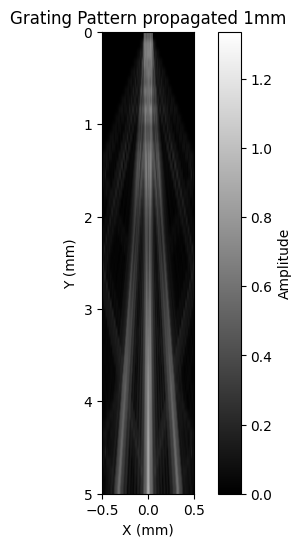

In [11]:
# Display the grating
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(array_3d[:, 512, :])**1, cmap="gray", extent=[-0.5, 0.5, 5, 0])
plt.colorbar(label="Amplitude")
plt.title("Grating Pattern propagated 1mm")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.show()

# 1.4
The result has a lot of ripples. This is unphysical. What happens in the simulation is, that some part of the energy diffracts out of the field of view. But our algorithm is not treating that correcty. 
What happens, because of the repetitive behaviour of the FFT, if a wave leaves the field of view, it will reappear on the other side again.

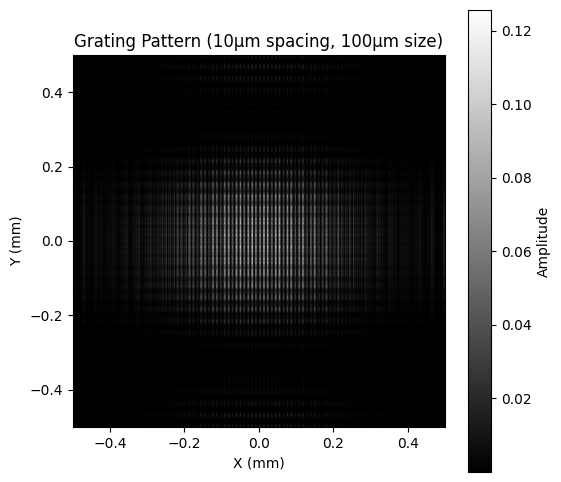

In [16]:
# Display the grating
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(angular_spectrum_propagation(grating, wvl, 50e-3, dx))**2, cmap="gray", extent=[-0.5, 0.5, -0.5, 0.5])
plt.colorbar(label="Amplitude")
plt.title("Grating Pattern (10µm spacing, 100µm size)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.show()

# 2 Double Slit Experiment

Calculate the 2D intensity of a double slit with slit width 2µm and slit distance 20µm.
Use 1024 samples for each dimension again. The pixel pitch is 1µm.
Propagate the pattern for 1.5mm. 

Does this match the theoretical expected curve? (See Wikipedia for the solution). Is the far field condition fulfilled (see Fresnel number)?

Just plot a 1D cross section of the propagated field, not the whole image.

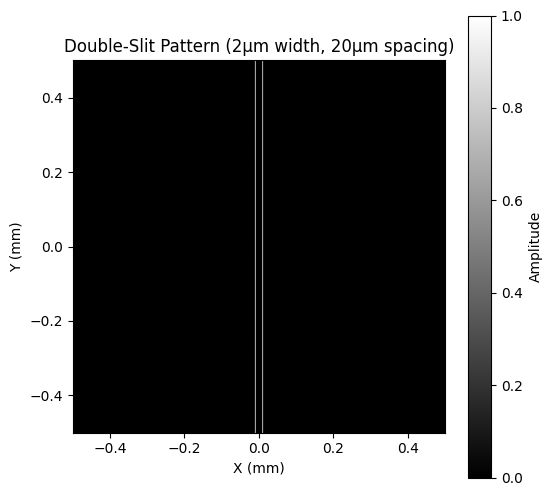

In [12]:
# Define parameters
num_pixels = 1024  # Resolution
dx = 1e-6
array_size = 1024 * dx  # 1mm total computational area
slit_width = 2e-6  # 2µm slit width
slit_spacing = 20e-6  # 20µm slit center-to-center spacing

# Create spatial coordinate grid
x = np.linspace(-array_size / 2, array_size / 2, num_pixels)
y = np.linspace(-array_size / 2, array_size / 2, num_pixels)
X, Y = np.meshgrid(x, y)

# Define slit positions
slit1 = np.abs(X - slit_spacing / 2) < (slit_width / 2)  # Right slit
slit2 = np.abs(X + slit_spacing / 2) < (slit_width / 2)  # Left slit

# Combine both slits
double_slit = (slit1 | slit2).astype(float)

# Display the double-slit pattern
plt.figure(figsize=(6, 6))
plt.imshow(double_slit, cmap="gray", extent=[-0.5, 0.5, -0.5, 0.5])
plt.colorbar(label="Amplitude")
plt.title("Double-Slit Pattern (2µm width, 20µm spacing)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.show()

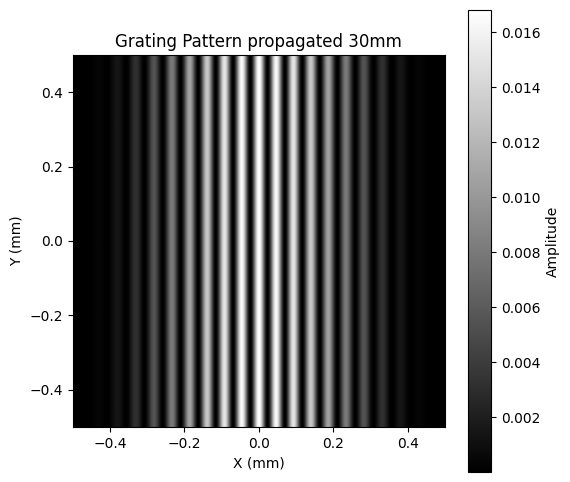

In [13]:
u_prop = angular_spectrum_propagation(double_slit, wvl, 1.5e-3, dx)

# Display the grating
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(u_prop)**2, cmap="gray", extent=[-0.5, 0.5, -0.5, 0.5])
plt.colorbar(label="Amplitude")
plt.title("Grating Pattern propagated 30mm")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.show()

In [14]:
def analytic_solution(x, z, b, d, wvl):
    theta = np.atan(x / z)
    tmp = np.pi * b * np.sin(theta) / wvl
    return np.cos(np.pi * d * np.sin(theta) / wvl)**2 * np.sinc(tmp / np.pi)**2

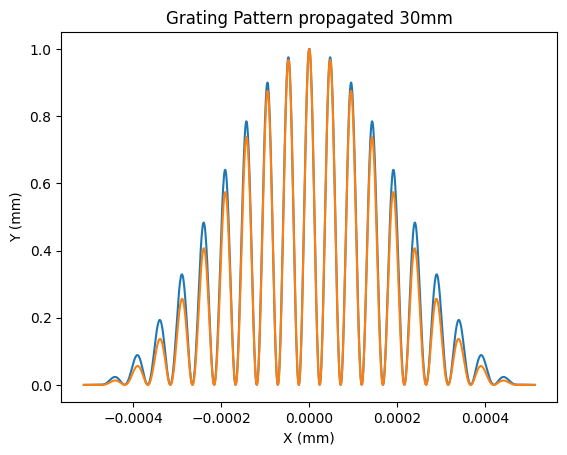

In [15]:
# Display the grating
line = np.abs(u_prop)[512, :]**2
plt.plot(x, line / np.max(line))
plt.plot(x, analytic_solution(x, 1.5e-3, slit_width, slit_spacing, wvl))
plt.title("Grating Pattern propagated 30mm")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.show()